In [1]:
from platform import python_version

print(python_version())

3.6.9


In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Implement me
# Set working directory
%cd /content/drive/"My Drive"/"Colab"/"NLP_Project"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab/NLP_Project


# Import Libraries

In [0]:
import pandas as pd
import plotly.express as px

import spacy
from spacy import displacy
from spacy.matcher import matcher
from spacy.lang.en import English
from spacy.pipeline import EntityRuler

spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
nlp = spacy.load('en_core_web_sm')
pd.options.display.max_colwidth = 1000


import copy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from  sklearn.metrics  import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from wordcloud import WordCloud, STOPWORDS 

In [3]:
print(spacy.__version__)

2.2.4


# Read In Dialog, Standardize Data

In [4]:
all_dialog_df = pd.read_csv('All-seasons.csv')
all_dialog_df.Line = all_dialog_df.Line.replace(r'\n',' ', regex=True)

cartman_names = ['Cartman\'s Conscience','Cartman\'s Good Side','Cartman\'s Bad Side','Cartman Smurf','Cheesy Poof Cartman','Evil Cartman','Both Cartmans','Cartman on Left','Cartman on Right','Cartman\'s voice','New Cartman','Future Cartman','Cartman\'s Side','Eric Cartman']
stan_names = ['Stan', 'Profile Stan Marsh', 'Stan Marsh', 'Big Stan', 'Stanley', 'Evil Stan', 'Future Stan']
kyle_names = ['Kyle','Kyles','Kyle Broflovski','Evil Kyle','Kyle.','Kyle Two','Kyle\'s Side','Kyle 1']

print('Pre-standardization Character Count: {0}'.format(len(all_dialog_df.Character.unique())))

all_dialog_df.loc[all_dialog_df.Character.str.contains('|'.join(cartman_names)), 'Character'] = 'Cartman'
all_dialog_df.loc[all_dialog_df.Character.str.contains('|'.join(stan_names)), 'Character'] = 'Stan'
all_dialog_df.loc[all_dialog_df.Character.str.contains('|'.join(kyle_names)), 'Character'] = 'Kyle'

print('Post-standardization Character Count: {0}'.format(len(all_dialog_df.Character.unique())))

Pre-standardization Character Count: 3950
Post-standardization Character Count: 3874


# Taking a peek at loaded file

In [5]:
all_dialog_df.head()

,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away."
1,10,1,Kyle,Going away? For how long?
2,10,1,Stan,Forever.
3,10,1,Chef,I'm sorry boys.
4,10,1,Stan,"Chef said he's been bored, so he joining a group called the Super Adventure Club."


# Checking for NaNs

In [6]:
# checking for nan in each col
print(all_dialog_df.isna().any()) 

Season       False
Episode      False
Character    False
Line         False
dtype: bool


# Distribution of Dialogues spoken by each character

In [7]:
# unique characters & dialogues spoken by each
all_dialog_df.Character.value_counts()

Cartman                    9843
Stan                       7867
Kyle                       7248
Butters                    2602
Randy                      2467
                           ... 
Press Coordinator             1
Man with Mustache             1
The New Lyrics, part II       1
Biker 9                       1
FC Fat Player                 1
Name: Character, Length: 3874, dtype: int64

# Calculate Character Statistics

In [8]:
character_stats = all_dialog_df.groupby('Character').count()['Line'].sort_values(ascending=False).to_frame()
character_stats = character_stats.rename(columns={"Character": "Characters", "Line": "Observations"})
character_stats['Percentage'] = (character_stats/len(all_dialog_df))*100
character_stats.head()

,Observations,Percentage
Character,,
Cartman,9843,13.883717
Stan,7867,11.096536
Kyle,7248,10.223426
Butters,2602,3.670165
Randy,2467,3.479745


# Get Main (top 3) Character Dialogues

In [9]:
csk_dialog_df = all_dialog_df[all_dialog_df.Character.isin(['Cartman', 'Stan', 'Kyle'])]
csk_dialog_df.head(10)

,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away."
1,10,1,Kyle,Going away? For how long?
2,10,1,Stan,Forever.
4,10,1,Stan,"Chef said he's been bored, so he joining a group called the Super Adventure Club."
9,10,1,Cartman,I'm gonna miss him. I'm gonna miss Chef and I...and I don't know how to tell him!
10,10,1,Stan,"Dude, how are we gonna go on? Chef was our fuh...f-ffriend."
19,10,1,Kyle,"Draw two card, fatass."
20,10,1,Cartman,"Reverse to you, Jew."
21,10,1,Stan,I'll get it.
23,10,1,Stan,He's back!


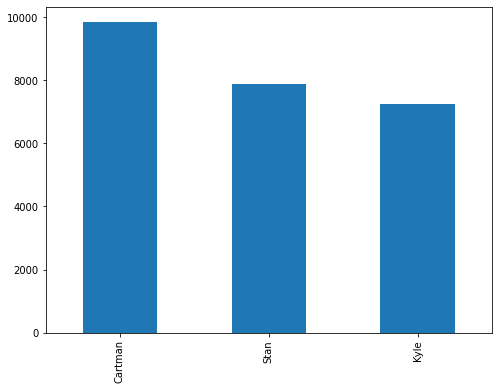

In [10]:
# Bar chart of dialogues spoken by top 3 characters
fig = plt.figure(figsize=(8,6))
csk_dialog_df.Character.value_counts().plot.bar(ylim=0)
plt.show()

In [11]:
csk_dialog_df.Character.value_counts()

Cartman    9843
Stan       7867
Kyle       7248
Name: Character, dtype: int64

# Generating a word cloud for each Character

## Word cloud for Cartman

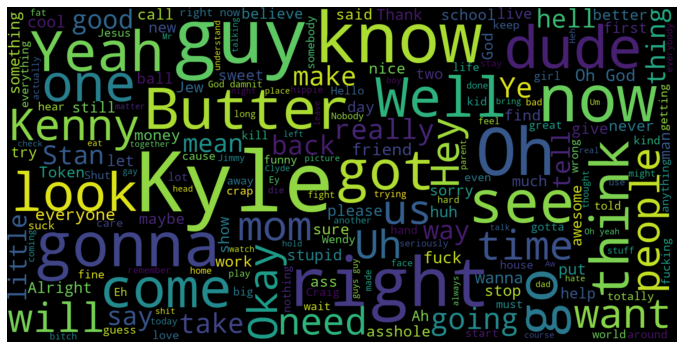

In [12]:
Cartman_df = csk_dialog_df.loc[csk_dialog_df['Character'] == 'Cartman']
Cartman_words = []   # creating a single list that would contain all dialogues
for i in Cartman_df.Line:
    Cartman_words.append(i)

Cartman_text = pd.Series(Cartman_words).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(Cartman_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Word cloud for Stan

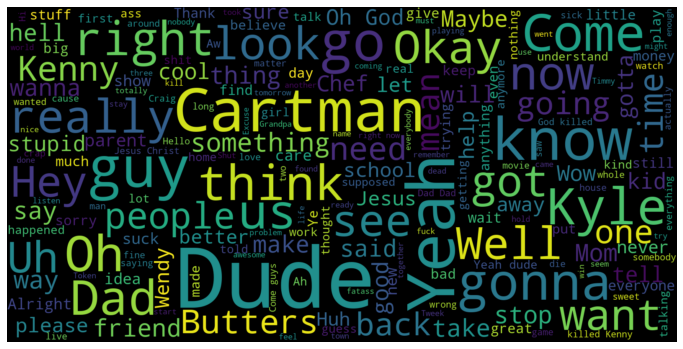

In [13]:
Stan_df = csk_dialog_df.loc[csk_dialog_df['Character'] == 'Stan']
Stan_words = []   # creating a single list that would contain all dialogues
for i in Stan_df.Line:
    Stan_words.append(i)

Stan_text = pd.Series(Stan_words).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(Stan_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Word cloud for Kyle

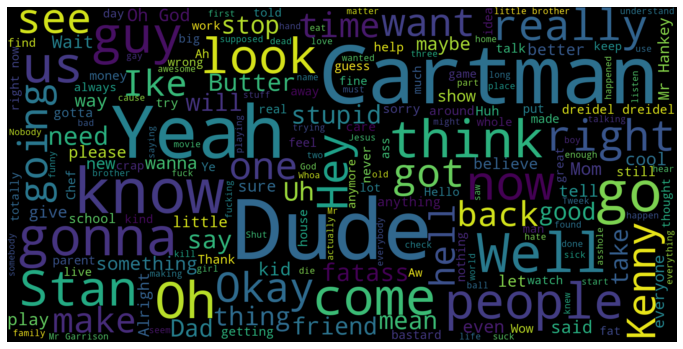

In [14]:
Kyle_df = csk_dialog_df.loc[csk_dialog_df['Character'] == 'Kyle']
Kyle_words = []   # creating a single list that would contain all dialogues
for i in Kyle_df.Line:
    Kyle_words.append(i)

Kyle_text = pd.Series(Kyle_words).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(Kyle_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Build Documents of Character Dialog for NER and Sentence Embedding

In [0]:
# with open('workdir/cartman_dialog.txt', 'w', encoding='utf-8') as f:   
#     f.writelines(csk_dialog_df[csk_dialog_df.Character.isin(['Cartman'])].Line)

# with open('workdir/cartman_dialog_no_stopwords.txt', 'w', encoding='utf-8') as f:   
#     for line in csk_dialog_df[csk_dialog_df.Character.isin(['Cartman'])].Line:
#         doc = nlp(line)
#         tokens = [token.text for token in doc if not token.is_stop]
#         f.writelines(" ".join(tokens))
        
# with open('workdir/stan_dialog.txt', 'w', encoding='utf-8') as f:   
#     f.writelines(csk_dialog_df[csk_dialog_df.Character.isin(['Stan'])].Line)

# with open('workdir/stan_dialog_no_stopwords.txt', 'w', encoding='utf-8') as f:   
#     for line in csk_dialog_df[csk_dialog_df.Character.isin(['Stan'])].Line:
#         doc = nlp(line)
#         tokens = [token.text for token in doc if not token.is_stop]
#         f.writelines(" ".join(tokens))
            
# with open('workdir/kyle_dialog.txt', 'w', encoding='utf-8') as f:   
#     f.writelines(csk_dialog_df[csk_dialog_df.Character.isin(['Kyle'])].Line)
    
# with open('workdir/kyle_dialog_no_stopwords.txt', 'w', encoding='utf-8') as f:   
#     for line in csk_dialog_df[csk_dialog_df.Character.isin(['Kyle'])].Line:
#         doc = nlp(line)
#         tokens = [token.text for token in doc if not token.is_stop]
#         f.writelines(" ".join(tokens))



In [17]:
!python3 -m spacy download en_core_web_md

     |████████████████████████████████| 96.4MB 1.1MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp36-none-any.whl size=98051305 sha256=b16a73b72fbdb080208341827c3d032f5ab621fae1ecfea14122d00f95a1d72f
  Stored in directory: /tmp/pip-ephem-wheel-cache-0_0b_ugb/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


# Sentence Embedding

In [18]:

import en_core_web_md
nlp = en_core_web_md.load()

def build_vectors_from_file(file_path):
    with open(file_path, 'r') as f:
        return (nlp(f.read()))

cartman_doc = build_vectors_from_file('workdir/cartman_dialog_no_stopwords.txt')
print('Cartman Document Built')

stan_doc = build_vectors_from_file('workdir/stan_dialog_no_stopwords.txt')  
print('Stan Document Built')

kyle_doc = build_vectors_from_file('workdir/kyle_dialog_no_stopwords.txt')
print('Kyle Document Built')



Cartman Document Built
Stan Document Built
Kyle Document Built


In [19]:
query_doc = nlp("Well, this was a great meeting. Wasn't it, guys? But, we gotta get goin' to school now.")

print(cartman_doc.similarity(query_doc))
print(stan_doc.similarity(query_doc))
print(kyle_doc.similarity(query_doc))

0.9210823907870881
0.929157707737528
0.9214379667051773


# Named Entity Recognition

In [20]:
ner_nlp = spacy.load("en_core_web_sm")
custom = English()

ruler = EntityRuler(nlp)
patterns = [{"label": "PERSON", "pattern": "Cartman", "id": "cartman"},
            {"label": "PERSON", "pattern": "Eric", "id": "cartman"},
            {"label": "PERSON", "pattern": "Eric Cartman", "id": "cartman"},
            {"label": "PERSON", "pattern": "Marsh", "id": "stan"},
            {"label": "PERSON", "pattern": "Stan", "id": "stan"},
            {"label": "PERSON", "pattern": "Stan Marsh", "id": "stan"},
            {"label": "PERSON", "pattern": "Broflovski", "id": "kyle"},
            {"label": "PERSON", "pattern": "Kyle", "id": "kyle"},
            {"label": "PERSON", "pattern": "Kyle Broflovski", "id": "kyle"}]

ruler.add_patterns(patterns)
ner_nlp.add_pipe(ruler) 

print(ner_nlp.pipeline)

doc = ner_nlp("Guys! Guys? Cartman? Can anybody hear me? You guys?? Token, Token, I'm here! Hello! Hello! Hello! Clyde, can't you feel me? Feel me, Clyde! Jimmy! Jimmy, it's me, Eric! Jimmy! Can't you feel your hair move?! That's me! They don't even know yet, that one of their best friends is dead. Dead and... still wandering the earth a lost soul")

displacy.render(doc, jupyter=True)
displacy.render(doc, style="ent", jupyter=True)

print([(ent.text, ent.label_, ent.ent_id_) for ent in doc.ents])

[('tagger', <spacy.pipeline.pipes.Tagger object at 0x7f8df88a1c18>), ('parser', <spacy.pipeline.pipes.DependencyParser object at 0x7f8dd3620ee8>), ('ner', <spacy.pipeline.pipes.EntityRecognizer object at 0x7f8dd3620f48>), ('entity_ruler', <spacy.pipeline.entityruler.EntityRuler object at 0x7f8df88a1828>)]


[('Cartman', 'PERSON', 'cartman'), ('Token', 'GPE', ''), ('Clyde', 'PERSON', ''), ('Clyde', 'PERSON', ''), ('Jimmy', 'PERSON', ''), ('Jimmy', 'PERSON', ''), ('Eric', 'PERSON', ''), ('Jimmy', 'PERSON', '')]


# Splitting data set


In [0]:
X_train, X_test, y_train, y_test = train_test_split(csk_dialog_df.Line, csk_dialog_df.Character, test_size = 0.2, random_state = 42)

# Feature Extraction using TF-IDF

In [22]:
# covert the text corpus into the feature vectors
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)
print(train_vectors.shape, test_vectors.shape)
# Now, each of 19966/4992 dialogues in train/test is represented by 215339 features

(19966, 215339) (4992, 215339)


In [23]:
# get the first vector out (for the first row in df)
first_vector_train_vectors=train_vectors[0]
 
# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_train_vectors.T.todense(), index=vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
can what,0.329229
stopping you,0.329229
what stopping,0.329229
you can what,0.329229
what stopping you,0.329229
...,...
have won,0.000000
have won it,0.000000
have word,0.000000
have word from,0.000000


# Applying different classification models (Naive Bayes, SVM, KNN, Random Forest)

In [0]:
# defining a function to display performance metrics of a model
def display_performance_metrics(y_test, model_predictions):
    print('Accuracy Score=', accuracy_score(y_test, model_predictions), '\n')
    
    # precision, recall, f1-score etc
    print(metrics.classification_report(y_test, model_predictions))
    
    # confusion matrix
    target_df = csk_dialog_df[['Character']].drop_duplicates().sort_values('Character')
    conf_mat = confusion_matrix(y_test, model_predictions)
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=target_df.Character.values, yticklabels=target_df.Character.values)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## Naive Bayes Classifier

Accuracy Score= 0.49158653846153844 

              precision    recall  f1-score   support

     Cartman       0.48      0.90      0.62      1959
        Kyle       0.60      0.15      0.24      1467
        Stan       0.51      0.31      0.38      1566

    accuracy                           0.49      4992
   macro avg       0.53      0.45      0.41      4992
weighted avg       0.52      0.49      0.43      4992



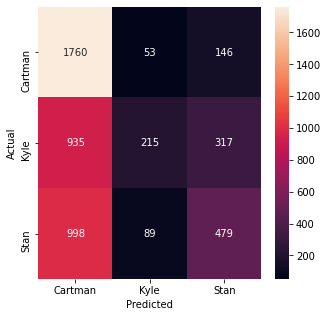

In [25]:
# basic Naive Bayes Classifier to train the model on the training set.
clf_naive = MultinomialNB().fit(train_vectors, y_train)


# testing the performance of our model on the test set to predict labels.
predictions_naive = clf_naive.predict(test_vectors)


display_performance_metrics(y_test, predictions_naive)

## SVM Classifier

Accuracy Score= 0.5262419871794872 

              precision    recall  f1-score   support

     Cartman       0.54      0.80      0.64      1959
        Kyle       0.53      0.30      0.39      1467
        Stan       0.49      0.40      0.44      1566

    accuracy                           0.53      4992
   macro avg       0.52      0.50      0.49      4992
weighted avg       0.52      0.53      0.50      4992



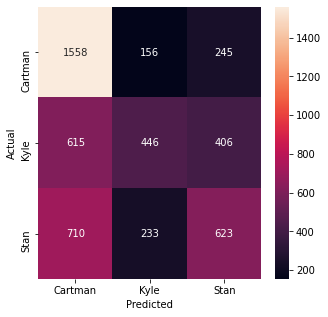

In [26]:
# using SVM to train the model on the training set.
clf_svm = SGDClassifier().fit(train_vectors, y_train)

predictions_svm = clf_svm.predict(test_vectors)

display_performance_metrics(y_test, predictions_svm)

## KNN Classifier

Accuracy Score= 0.4362980769230769 

              precision    recall  f1-score   support

     Cartman       0.44      0.84      0.58      1959
        Kyle       0.42      0.15      0.22      1467
        Stan       0.45      0.20      0.28      1566

    accuracy                           0.44      4992
   macro avg       0.43      0.40      0.36      4992
weighted avg       0.43      0.44      0.38      4992



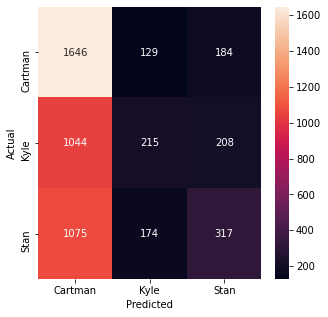

In [27]:
# using KNN with k=3 to train the model on the training set.
clf_knn = KNeighborsClassifier(n_neighbors=3).fit(train_vectors, y_train)

predictions_knn = clf_knn.predict(test_vectors)

display_performance_metrics(y_test, predictions_knn)

## Random Forest Classifier

Accuracy Score= 0.4907852564102564 

              precision    recall  f1-score   support

     Cartman       0.56      0.64      0.60      1959
        Kyle       0.46      0.32      0.37      1467
        Stan       0.42      0.47      0.44      1566

    accuracy                           0.49      4992
   macro avg       0.48      0.47      0.47      4992
weighted avg       0.49      0.49      0.48      4992



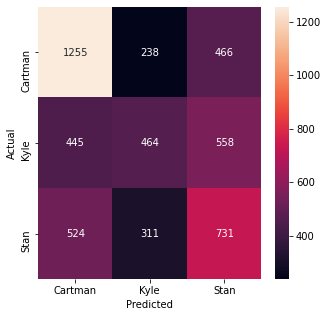

In [28]:
# using RandomForest to train the model on the training set.

from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier().fit(train_vectors, y_train)

predictions_rf = clf_rf.predict(test_vectors)

display_performance_metrics(y_test, predictions_rf)

# Applying TF-IDF with stop words removed

In [29]:
# covert the text corpus into the feature vectors
vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words='english')
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)
print(train_vectors.shape, test_vectors.shape)
# Now, each of 19984/4996 dialogues in train/test is represented by 78912 features

# get the first vector out (for the first row in df)
first_vector_train_vectors=train_vectors[0]
 
# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_train_vectors.T.todense(), index=vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

(19966, 128633) (4992, 128633)


,tfidf
yes stopping,0.691285
stopping,0.629238
yes,0.355224
000,0.000000
peru land,0.000000
...,...
gonna zingy tangy,0.000000
gonna zingy,0.000000
gonna write mascot,0.000000
gonna write,0.000000


********************************************
RESULT FROM NAIVE BAYES MODEL
********************************************
Accuracy Score= 0.49659455128205127 

              precision    recall  f1-score   support

     Cartman       0.49      0.87      0.63      1959
        Kyle       0.57      0.19      0.29      1467
        Stan       0.49      0.32      0.38      1566

    accuracy                           0.50      4992
   macro avg       0.52      0.46      0.43      4992
weighted avg       0.51      0.50      0.45      4992



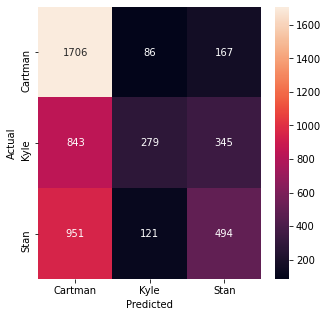

********************************************
RESULT FROM SVM MODEL
********************************************
Accuracy Score= 0.5124198717948718 

              precision    recall  f1-score   support

     Cartman       0.53      0.77      0.63      1959
        Kyle       0.49      0.31      0.38      1467
        Stan       0.48      0.38      0.42      1566

    accuracy                           0.51      4992
   macro avg       0.50      0.49      0.48      4992
weighted avg       0.50      0.51      0.49      4992



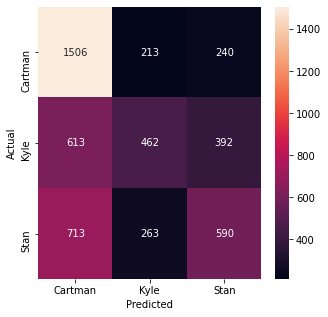

********************************************
RESULT FROM KNN MODEL
********************************************
Accuracy Score= 0.33994391025641024 

              precision    recall  f1-score   support

     Cartman       0.45      0.17      0.25      1959
        Kyle       0.38      0.12      0.18      1467
        Stan       0.31      0.76      0.44      1566

    accuracy                           0.34      4992
   macro avg       0.38      0.35      0.29      4992
weighted avg       0.39      0.34      0.29      4992



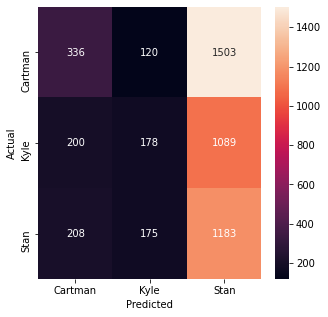

********************************************
RESULT FROM RANDOM FOREST MODEL
********************************************
Accuracy Score= 0.4895833333333333 

              precision    recall  f1-score   support

     Cartman       0.59      0.58      0.59      1959
        Kyle       0.44      0.36      0.40      1467
        Stan       0.42      0.50      0.46      1566

    accuracy                           0.49      4992
   macro avg       0.48      0.48      0.48      4992
weighted avg       0.49      0.49      0.49      4992



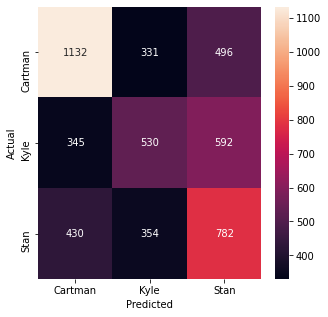

In [30]:
print('********************************************')
print('RESULT FROM NAIVE BAYES MODEL')
print('********************************************')
# basic Naive Bayes Classifier to train the model on the training set.
clf_naive = MultinomialNB().fit(train_vectors, y_train)
# testing the performance of our model on the test set to predict labels.
predictions_naive = clf_naive.predict(test_vectors)
display_performance_metrics(y_test, predictions_naive)

print('********************************************')
print('RESULT FROM SVM MODEL')
print('********************************************')
# using SVM to train the model on the training set.
clf_svm = SGDClassifier().fit(train_vectors, y_train)
predictions_svm = clf_svm.predict(test_vectors)
display_performance_metrics(y_test, predictions_svm)


print('********************************************')
print('RESULT FROM KNN MODEL')
print('********************************************')
# using KNN with k=3 to train the model on the training set.
clf_knn = KNeighborsClassifier(n_neighbors=3).fit(train_vectors, y_train)
predictions_knn = clf_knn.predict(test_vectors)
display_performance_metrics(y_test, predictions_knn)


print('********************************************')
print('RESULT FROM RANDOM FOREST MODEL')
print('********************************************')
# using RandomForest to train the model on the training set.
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier().fit(train_vectors, y_train)
predictions_rf = clf_rf.predict(test_vectors)
display_performance_metrics(y_test, predictions_rf)

# Recurrent Neural Network

In [31]:
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers

Using TensorFlow backend.


In [0]:
df = csk_dialog_df[['Character', 'Line']]

Vectorize dialogues, by turning each dialogue into either a sequence of integers or into a vector.

In [33]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each dialogue.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Line'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 12457 unique tokens.


Truncate and pad the input sequences so that they are all in the same length for modeling.

In [34]:
X = tokenizer.texts_to_sequences(df['Line'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (24958, 250)


Converting categorical labels to numbers.

In [35]:
Y = pd.get_dummies(df['Character']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (24958, 3)


In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(19966, 250) (19966, 3)
(4992, 250) (4992, 3)


# Defining the Recurrent Neural Network Model
    - The first layer is the embedded layer that uses 100 length vectors to represent each word.
    - SpatialDropout1D performs variational dropout in NLP models.
    - The next layer is the LSTM layer with 100 memory units.
    - The output layer must create 3 output values, one for each class.
    - Activation function is softmax for multi-class classification.
    - Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

In [40]:
model = models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)


Train on 17969 samples, validate on 1997 samples
Epoch 1/5
17969/17969 [==============================] - 135s 8ms/step - loss: 1.0330 - accuracy: 0.4542 - val_loss: 0.9687 - val_accuracy: 0.5078
Epoch 2/5
17969/17969 [==============================] - 134s 7ms/step - loss: 0.9098 - accuracy: 0.5599 - val_loss: 0.9448 - val_accuracy: 0.5198
Epoch 3/5
17969/17969 [==============================] - 135s 7ms/step - loss: 0.8143 - accuracy: 0.6216 - val_loss: 0.9747 - val_accuracy: 0.5213
Epoch 4/5
17969/17969 [==============================] - 133s 7ms/step - loss: 0.7354 - accuracy: 0.6607 - val_loss: 1.0495 - val_accuracy: 0.5163
Epoch 5/5
17969/17969 [==============================] - 134s 7ms/step - loss: 0.6810 - accuracy: 0.6863 - val_loss: 1.0733 - val_accuracy: 0.5143


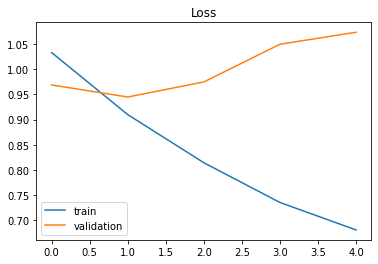

In [43]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show();

In [41]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

4992/4992 [==============================] - 6s 1ms/step
Test set
  Loss: 1.098
  Accuracy: 0.513
